In [1]:
import geopandas as gpd
import pandas as pd
import os
import leafmap
from samgeo import SamGeo, raster_to_vector, overlay_images

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import cv2
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio

In [3]:
from magic_pen.config import *
from magic_pen.io import *
from magic_pen.seg_any_change.utils import load_levircd_sample

In [ ]:
def load_img(img_path):
    img = io.imread(img_path)
    return img

def show_img(img, show_axis=False):
    io.imshow(img)
    if not show_axis:
        plt.axis("off")

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

#### Load data

In [ ]:
pair_img = load_levircd_sample(1, seed=42)

path_label,path_A, path_B = pair_img.iloc[0]

In [9]:
img_A = load_img(path_B)

In [10]:
img_A.shape

(1024, 1024, 3)

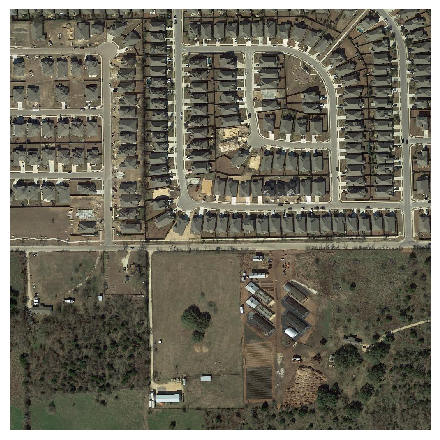

In [11]:
show_img(img_A)

### Automatic mask generation - SAM

In [12]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

In [13]:
def load_sam(model_type: str):
    sam = sam_model_registry[model_type](checkpoint=sam_model_large)
    _ = sam.to(device=DEVICE)
    return sam

```python
class SamAutomaticMaskGenerator:
    def __init__(
        self,
        model: Sam,
        points_per_side: Optional[int] = 32,
        points_per_batch: int = 64,
        pred_iou_thresh: float = 0.88,
        stability_score_thresh: float = 0.95,
        stability_score_offset: float = 1.0,
        box_nms_thresh: float = 0.7,
        crop_n_layers: int = 0,
        crop_nms_thresh: float = 0.7,
        crop_overlap_ratio: float = 512 / 1500,
        crop_n_points_downscale_factor: int = 1,
        point_grids: Optional[List[np.ndarray]] = None,
        min_mask_region_area: int = 0,
        output_mode: str = "binary_mask",
    ) -> None:
        """
        Using a SAM model, generates masks for the entire image.
        Generates a grid of point prompts over the image, then filters
        low quality and duplicate masks. The default settings are chosen
        for SAM with a ViT-H backbone.

        Arguments:
          model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
        """

```

In [50]:
model_type = "vit_h"
sam = load_sam(model_type)
mask_generator = SamAutomaticMaskGenerator(sam)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

* segmentation : the mask
* area : the area of the mask in pixels
* bbox : the boundary box of the mask in XYWH format
* predicted_iou : the model's own prediction for the quality of the mask
* point_coords : the sampled input point that generated this mask
* stability_score : an additional measure of mask quality
* crop_box : the crop of the image used to generate this mask in XYWH format

In [51]:
masks = mask_generator.generate(img_A)

In [52]:
print(len(masks))
print(masks[0].keys())

240
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


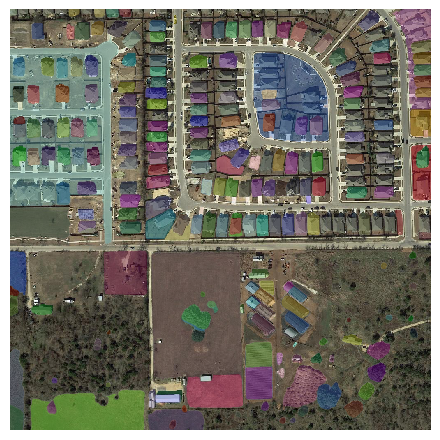

In [58]:
show_img(img_A)
show_anns(masks)

* Faire varier `n_crop_layer` pour récupérer des masks plus granulaires, i.e identifier toutes les maisons ?
* postprocessing with `min_mask_region_area` : fill holes and rm disconnected regions

240
CPU times: user 35.7 s, sys: 16.9 s, total: 52.6 s
Wall time: 52.5 s


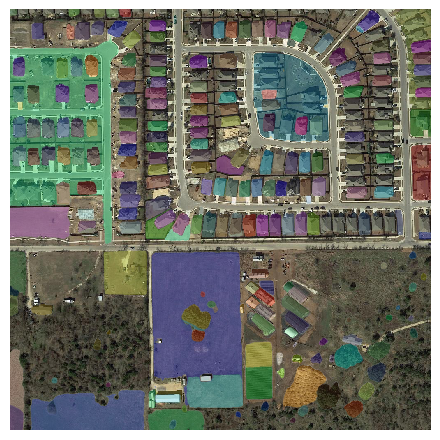

In [61]:
%%time
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95,
    crop_n_layers=2, # update
    crop_n_points_downscale_factor=2, # update
    min_mask_region_area=0, 
)
masks2 = mask_generator_2.generate(img_A)
print(len(masks))
show_img(img_A)
show_anns(masks)

240
CPU times: user 5min 52s, sys: 2min 49s, total: 8min 41s
Wall time: 8min 29s


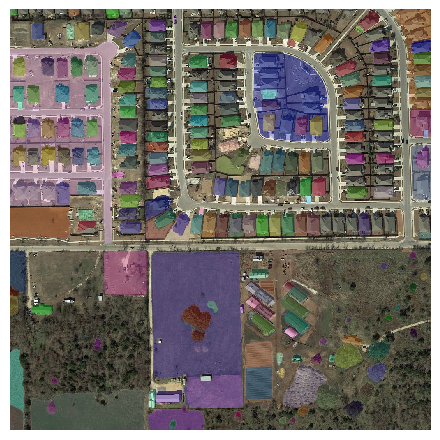

In [64]:
%%time
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95,
    crop_n_layers=3, # update
    crop_n_points_downscale_factor=1, # update
    min_mask_region_area=0, 
)
masks2 = mask_generator_2.generate(img_A)
print(len(masks))
show_img(img_A)
show_anns(masks)

* Inférence assez longue selon le nombre de layer `n_crop_layer` 
* Influence de `crop_n_points_downscale_factor` => scale le nombre de points par crop (n_pts = n_pts_0/(crop_n_points*depth))? Etudier nombre de masks récupérer.
* Nombre de masks est constant à 240 en faisant varier `crop_n_points_downscale_factor` et `n_crop_layer` ? => Seuil de confiance filtres les masques ? Peu d'influence dans ce cas.
* Seuil de décisions par défault élevés => priviligie haut niveau de confiance. A quoi ressemble les masques à un faible niveau de confiance ?
    * pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
    * stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          * from the *source* : The stability
    score is the IoU between the binary masks obtained by thresholding
    the predicted mask logits at high and low values.

### Convert png to tiff

In [10]:
#TO DO : coords available in levircd folder

In [11]:
from shapely import Polygon
from shapely import box
import json

with open(make_path("LEVIR_CD_name_coords.geojson", levirCD_path)) as f:
    feats = json.load(f)
    
geom = [Polygon(pt["geometry"]["coordinates"]) for pt in feats["features"]]
names = [pt["properties"]["name"] for pt in feats["features"]]
feats = gpd.GeoDataFrame(names, geometry=geom, crs=4326, columns=["name"])
feats.to_file(make_path("LEVIR_CD_name_coords.gpkg", levirCD_path), driver='GPKG')

In [12]:
def png_to_geotiff(img_path, bounds, output_file_path=None, bands=[1, 2, 3], crs={"init":"epsg:4326"}):
    with rio.open(img_path, 'r') as src:
        bands = [1, 2, 3]
        data = src.read(bands)
        # bounds : west, south, east, north
        transform = rio.transform.from_bounds(*bounds,
                                              data.shape[1],
                                              data.shape[2])

        _, height, width = data.shape

        if output_file_path is None:
            output_file_path = make_path("tmp.tiff", os.getcwd())
        with rio.open(output_file_path,
                           'w',
                           driver='GTiff',
                           width=width,
                           height=height,
                           count=3,
                           dtype=data.dtype,
                           nodata=0,
                           transform=transform,
                           crs=crs
                          ) as dst:
            dst.write(data, indexes=bands)
            
    return output_file_path

In [13]:
def get_coords_from_shape(geom):
    return list(zip(*geom.exterior.coords.xy))[:-1]

In [14]:
name = os.path.basename(path_label)
geom = feats.loc[feats.name == name, "geometry"].item()
bbox = box(*geom.bounds)
#coords = get_coords_from_shape(bbox)
path_tiff = png_to_geotiff(path_A, bbox.bounds)

### SAMGeo

In [19]:
m = leafmap.Map(height="600px")
#m.add_basemap("SATELLITE")
m.add_raster("image.tif", layer_name="Image")
m.add_layer_manager()

m

HTTPError: 503 Server Error: Service Unavailable for url: http://127.0.0.1:37273/api/metadata?&filename=%2Fhome%2FMDizier%2Fprojects%2Fstage_stylo_magique_2024%2Fnotebooks%2Fexploration%2Fimage.tif

Issue with Remote server & localtileserver : https://github.com/banesullivan/localtileserver/issues/29

Maybe a solution : https://github.com/banesullivan/localtileserver/issues/29

In [16]:
from localtileserver import get_leaflet_tile_layer, TileClient

In [42]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 80,
}

In [43]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
    checkpoint_dir=sam_model_large
)

Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /home/MDizier/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth


Model checkpoint for vit_h not found.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.56G/2.56G [07:53<00:00, 5.41MB/s]


In [ ]:
sam.generate(path_tiff, output="mask.tif", foreground=True)

In [ ]:
raster_to_vector("mask.tif", output="mask.shp")

In [ ]:
sam.show_anns(axis="off", opacity=1, output="annotation.png")